# Hồi quy tuyến tính
*Hoàn thành toàn bộ phần bài tập trong notebook này, bao gồm toàn bộ kết quả đầu ra và code hỗ trợ.*

***"Không có một sự kiện nào trên đời là ngẫu nhiên, những thứ đang cho là ngẫu nhiên chỉ là những sự kiện ta chưa tìm ra được mô hình để biểu diễn quy luật của chúng".***

Xây dựng mô hình **Hồi quy tuyến tính** bao gồm hai phần:
- Trong quá trình huấn luyện, bộ phân lớp lấy dữ liệu huấn luyện và và học các tham số mô hình.
- Trong quá trình kiếm tra, mô hình phân lớp từng đối tượng bằng cách nhân giá trị của mẫu với các tham số mô hình để tìm ra giá trị của nhãn.
- Giá trị của tham số được kiểm định chéo.
Trong bài tập này, bạn sẽ cài đặt những bước trên và hiểu được qui trình Xây dựng một mô hình đơn giản với Học tham số, kiểm định chéo, và hiểu được cách viết code hiệu quả với vectorize.

Bài toán dự đoán giá nhà Boston được sử dụng trong bài tập này.

In [1]:
# Import một số thư viện cần thiết.
import random
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

# Sử dụng một mẹo nhỏ để vẽ hình trên cùng một dòng thay vì mở cửa sổ mới
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # đặt kích thước mặc định cho hình
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Một mẹo nhỏ để notebook tự load lại các module bên ngoài;
# xem thêm tại http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Tải dữ liệu Giá nhà Boston từ Scikit-learn.
boston = datasets.load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, \
                                                    boston.target, test_size=0.2)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (404, 13)
Training labels shape:  (404,)
Test data shape:  (102, 13)
Test labels shape:  (102,)


## Load dữ liệu
Hồi qui tuyến tính đơn giản là một cách tiếp cận để dự đoán phản ứng (giá trị đầu ra) khi dữ liệu có một đặc trưng duy nhất. Khi giả sử hai biến $x$ và $y$ liên hệ tuyến  tính thì mục tiêu của mô hình là cố tìm ra đường tuyến tính tốt nhất để dự đoán phản ứng ($y$). 

Đường đó được gọi là đường hồi quy.

Công thức cho đường hồi quy được biểu diễn như sau:
$$ \hat{Y} = h(X) = XW$$
Trong đó: 

- $X$ là ma trận có kích thước $N \times D$ với $X_{ij}$ là giá trị của đặc trưng thứ $j$ của mẫu $i$.
- $W$ là ma trận tham số có kích thước $D \times 1$
- $Y$ là giá trị phản ứng của $N$ mẫu.



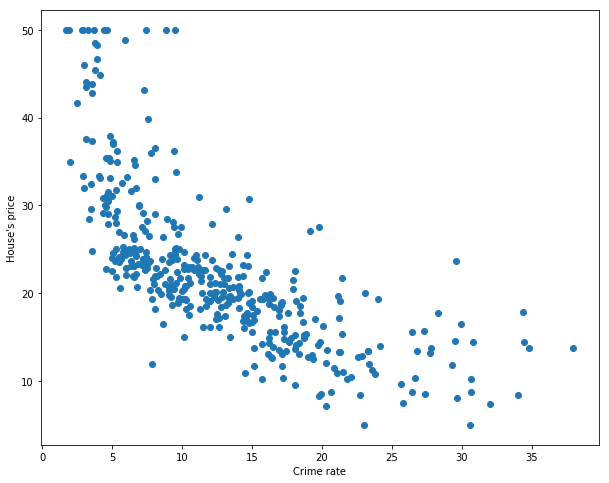

In [3]:
# Biểu diễn một số ví dụ trong tập huấn luyện sử dụng một đặc trưng duy nhất.
# LSTAT - % lower status of the population
plt.scatter(X_train[:,12], y_train)
plt.xlabel("Crime rate")
plt.ylabel("House's price")
plt.show()

## Huấn luyện mô hình
Tất cả code cho phần bài tập này được lưu trong tệp **models/linear_regression.py** và **models/linear_loss.py**.
### Cập nhật tham số
Quá trình huấn luyện mô hình thực chất là từ dữ liệu để học ra tham số mô hình phù hợp nhất với mô hình sinh dữ liệu. Trong mô hình hồi quy tuyến tính, ta cần học tham số $W$.

Khi khởi tạo mô hình, ta giả sử tham số được khởi tạo ngẫu nhiên. Sử dụng tham số $W$ đó, ta ước lượng được giá trị $Y$:
$$ \hat{y} = h(X) = WX $$

Tổng sai số, độ lệch của giá trị dự đoán so với giá trị thực tế gọi là hàm giá trị (Cost function):
$$ J(w) = \frac{1}{2N}\sum_{i=1}^{N} (\hat{y}_i - y_i)^2 = \frac{1}{2N}\sum_{i=1}^{N}\sum_{j=1}^{D} (w_{j}x_{ij} - y_{ij})^2$$


Chúng ta sử thuật toán **xuống đồi (Gradient descent)** để tối ưu tham số $W$. (Xem khóa [Machine Learning](https://www.coursera.org/learn/machine-learning/))

Đột tụt dốc của tham số $W$ được cập nhật theo công thức:
$$ dw_i = \frac{\partial}{\partial w_i}J(w)$$

Đầu tiên, mở file ```models/linear_loss.py``` và cài đặt hàm ```linear_loss_naive```, sử dụng vòng lặp để tính hàm giá trị (Cost function).

In [4]:
from models.linear_loss import linear_loss_naive
import time

# sinh ngẫu nhiên các trọng số (W) với các giá trị nhỏ
W = np.random.randn(13, ) * 0.0001 

loss, grad = linear_loss_naive(W, X_test, y_test, 0.00001)
print('loss: %f' % (loss, ))

loss: 308.902225


Lúc này, các giá trị gradient được trả về đều bằng 0. Đạo hàm và tính gradient theo công thức được cho ở trên trong cùng hàm ```linear_loss_naive```. Bạn sẽ thấy một số thứ hữu ích trong phần cài đặt trước đó.

Để đảm bảo là bạn đã cài đặt đúng, chúng ta sẽ sử dụng hàm ```grad_check_sparse``` (đã được cài đặt sẵn) để kiểm tra.

In [5]:
# Bởi vì bạn đã cài đặt hàm gradient, tính toán gradient với code dưới đây và
# kiểm tra với hàm grad_check_sparse(...) đã cho.

# Tính toán loss và grad với W.
loss, grad = linear_loss_naive(W, X_test, y_test, 0.0)

# Tính toán gradient theo một số chiều ngẫu nhiên và so sánh chúng với kết quả
# của bạn. Giá trị phải gần như chính xác theo tất cả các chiều.
from models.gradient_check import grad_check_sparse
f = lambda w: linear_loss_naive(w, X_test, y_test, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# thực hiện kiểm tra khi có sử dụng regularization
# đừng quên cài đặt gradient với regularization nhé.
loss, grad = linear_loss_naive(W, X_test, y_test, 1e2)
f = lambda w: linear_loss_naive(w, X_test, y_test, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Kết quả relative error trong khoảng 1e-12

numerical: -1.572114 analytic: -1.572114, relative error: 2.510060e-10
numerical: -1413.744382 analytic: -1413.744382, relative error: 8.208805e-13
numerical: -239.189586 analytic: -239.189586, relative error: 1.084267e-11
numerical: -91.171015 analytic: -91.171015, relative error: 2.357741e-11
numerical: -239.189586 analytic: -239.189586, relative error: 1.084267e-11
numerical: -8739.615045 analytic: -8739.615045, relative error: 5.900529e-14
numerical: -181.528574 analytic: -181.528574, relative error: 1.553554e-11
numerical: -1413.744382 analytic: -1413.744382, relative error: 8.208805e-13
numerical: -150.751128 analytic: -150.751128, relative error: 1.733476e-11
numerical: -1413.744382 analytic: -1413.744382, relative error: 8.208805e-13
numerical: -232.723135 analytic: -232.723135, relative error: 1.913945e-11
numerical: -8739.596792 analytic: -8739.596792, relative error: 1.180108e-13
numerical: -403.276428 analytic: -403.276428, relative error: 6.258216e-12
numerical: -403.26324

In [6]:
# Kế tiếp, cài đặt linear_loss_vectorized; hiện tại chỉ tính toán hàm giá trị;
# gradient sẽ cài đặt sau.
tic = time.time()
loss_naive, grad_naive = linear_loss_naive(W, X_test, y_test, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

# Vectorized
from models.linear_loss import linear_loss_vectorized
tic = time.time()
loss_vectorized, _ = linear_loss_vectorized(W, X_test, y_test, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# Hàm giá trị khi vectorized nên có cùng giá trị với giá trị được tính bằng hàm
# linear_loss_naive() nhưng tính toán nhanh hơn
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 3.089022e+02 computed in 0.019515s
Vectorized loss: 3.089022e+02 computed in 0.009979s
difference: -0.000000


In [7]:
# Hoàn thiện phần cài đặt của linear_loss_vectorized, và tính toán gradient theo
# cách vectorized.

# Hai hàm tính loss và gradient nên cho kết quả giống nhau nhưng bản vectorized 
# tính toán nhanh hơn.
tic = time.time()
_, grad_naive = linear_loss_naive(W, X_test, y_test, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = linear_loss_vectorized(W, X_test, y_test, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# So sánh gradient
difference = np.linalg.norm(grad_naive - grad_vectorized)
print('difference: {}'.format(difference))

Naive loss and gradient: computed in 0.017512s
Vectorized loss and gradient: computed in 0.000502s
difference: 3.182604911552452e-14


### Huấn luyện với hàm cập nhật
Sử dụng các hàm ```loss``` đã cài đặt ở trên để cài đặt hàm ```train``` trong tệp **linear_regression.py**.

Tham số W được cập nhật từng thành phần theo công thức:
$$ w_i =  w_i -\alpha\frac{\partial}{\partial w_i}J(w)$$

In [8]:
# Ở trong tệp linear_regression.py, cài đặt hàm LinearRegression.train() và chạy
# hàm đó với code sau
from models.linear_regression import LinearRegression
clf = LinearRegression()
tic = time.time()
loss_hist = clf.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

[[ -120.63998102]
 [ -283.45808463]
 [ -178.75543084]
 [  -30.15146688]
 [   87.78975142]
 [ -170.71742131]
 [-1519.95506057]
 [ -164.78938365]
 [ -191.21137413]
 [-8469.66918234]
 [ -465.86366834]
 [-8336.21139035]
 [ -274.8064    ]]
iteration 0 / 1500: loss 296.884347
[[ -22.73383812]
 [ -44.34728656]
 [  33.13176537]
 [ -17.33143764]
 [  60.1238794 ]
 [ -26.46288581]
 [ -51.21981208]
 [ -54.28048222]
 [  11.33025843]
 [  97.79214556]
 [ -52.68848959]
 [-602.00280502]
 [  -7.0839386 ]]
iteration 100 / 1500: loss 91.133034
[[ -14.38414264]
 [ -20.00055015]
 [  22.3682952 ]
 [ -10.46743287]
 [  36.60087468]
 [ -13.61099802]
 [ -10.27421992]
 [ -31.03157425]
 [   7.65207907]
 [ 154.57287001]
 [ -25.27826561]
 [-198.80743057]
 [  -0.98451067]]
iteration 200 / 1500: loss 89.457651
[[ -9.6435918 ]
 [-10.24421439]
 [ 12.95280065]
 [ -6.33662327]
 [ 22.17598167]
 [ -7.982522  ]
 [ -6.55872232]
 [-18.43265936]
 [  3.45605267]
 [ 76.76144267]
 [-14.81976447]
 [-92.1910978 ]
 [ -0.90816834]]
it

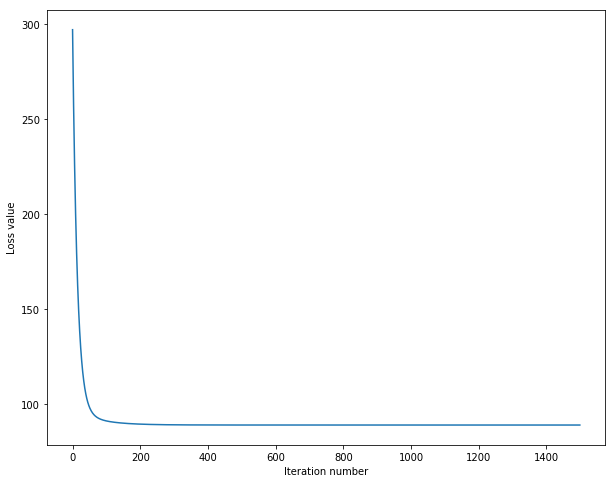

In [9]:
# Một chiến thuật debug hiệu quả được sử dụng đó là vẽ ra lịch sử mất mát (loss 
# history) như là một hàm với số lần lặp.
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [10]:
# Cài đặt hàm LinearRegression.predict đánh giá hiệu năng mô hình trên cả tập
# huấn luyện và tệp kiểm tra.
y_train_pred = clf.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_test_pred = clf.predict(X_test)
print('validation accuracy: %f' % (np.mean(y_test == y_test_pred), ))

training accuracy: 0.000000
validation accuracy: 0.000000


### Sự chính quy hóa (Regularization)

Regularization, một cách cơ bản, là thay đổi mô hình một chút để tránh overfitting trong khi vẫn giữ được tính tổng quát của nó (tính tổng quát là tính mô tả được nhiều dữ liệu, trong cả tập training và test).

Có rất nhiều phương pháp được sử dụng để chính quy hóa một mô hình, trong đó, chúng ta sẽ tìm hiểu về phương pháp $L_2 \, regularization$.

#### Regularized loss function
Kỹ thuật regularization phổ biến nhất là thêm vào hàm mất mát một số hạng nữa. Số hạng này thường dùng để đánh giá độ phức tạp của mô hình. Số hạng này càng lớn, thì mô hình càng phức tạp. Hàm mất mát mới này thường được gọi là `regularized loss function`, thường được định nghĩa như sau:
$$ J_{reg}(\theta) = J(\theta) + \lambda R(\theta)$$

Trong đó:
- $\theta$ là tham số mô hình (trong trường hợp này là $w$)
- $\lambda$ là hằng số regularization
- $R(\theta)$ là số hạng regularization

Kỹ thuật `l2 regularization`sử dụng $R(\theta) = R(w) = ||w||_2^2$.

#### Cập nhật tham số
Do tham số được cập nhật dựa trên đạo hàm của hàm mất mát, ta cần xây dựng lại công thức tính đạo hàm theo cách sau:
$$ w_i =  w_i -\alpha\frac{\partial}{\partial w_i}J_{reg}(w)$$

** Bài tập:** Dựa trên 2 công thức chuẩn hóa có ở trên, viết lại code cho bộ phân lớp `Linear Regression` và chạy tiếp code sau để tìm được mô hình tối ưu.

In [13]:
# Sử dụng tập kiểm tra để điều chỉnh các siêu tham số (độ lớn của reg và tỉ
# lệ học. Bạn nên thực nghiệm với nhiều khoảng giá trị của 2 siêu tham số này
# Nếu bạn đủ cẩn thận, bạn có thể đạt độ chính xác ... trên tập kiểm tra.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [5e4, 1e5]

# kết quả là một từ điển ánh xạ từ tuple có dạng (reg, lr) sang tuple có dạng
# (train_acc, test_acc). Độ chính xác chỉ đơn giản là tỉ lệ mẫu dự đoán chính
# xác trên toàn tập dữ liệu.
results = {}
best_test = -1   # Hiệu năng tốt nhất mà chúng ta sẽ đạt được.
best_linear = None # Mô hình LinearRegression có hiệu năng tốt nhất.

################################################################################
# TODO:                                                                        #
# Viết code chọn các siêu tham số tốt nhất bằng cách điều chỉnh trên tập kiểm  #
# tra. Với mỗi tổ hợp siêu tham số, huấn luyện một mô hình LinearRegression    #
# trên tập huấn luyện, tính toán độ chính xác trên tập huấn luyện và tập kiểm  #
# tra, và lưu những con số này vào từ điển kết quả. Thêm vào đó, lưu hiệu năng #
# tốt nhất trên tập kiểm tra vào best_val và mô hình LinearRegression tương    #
# ứng vào best_svm.                                                            #  
#                                                                              #
# Gợi ý: Bạn nên sử dụng số vòng lặp (num_iters) nhỏ khi xây dựng code kiểm    #
# tra để mô hình không mất quá nhiều thời gian để huấn luyện. Khi đã chắc chắn,#
# bạn nên trả về kết quả với số vòng lặp lớn                                   #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        clf = LinearRegression()
        clf.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=True)
            
        y_train_pred = clf.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_test_pred = clf.predict(X_test)
        test_acc = np.mean(y_test == y_test_pred)
            
        results[(lr, reg)] = (train_acc, test_acc)
################################################################################
#                              KẾT THÚC                                        #
################################################################################
    
# In kết quả
for lr, reg in sorted(results):
    train_accuracy, test_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, test_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_test)

[[ -132.66287852]
 [ -336.28088846]
 [ -234.86696939]
 [   38.27353113]
 [  -34.52932927]
 [ -130.04842161]
 [-1396.43481334]
 [  -40.16560195]
 [ -182.97853105]
 [-7944.0640572 ]
 [ -355.12136167]
 [-7982.5017922 ]
 [ -293.98418913]]
iteration 0 / 1500: loss 276.818202
[[ -33.17074652]
 [ -82.18625023]
 [  -8.80207534]
 [  24.06961348]
 [ -14.34763608]
 [  -5.87000186]
 [ -23.80051566]
 [  18.92698932]
 [   8.88987668]
 [ 125.45116686]
 [   2.1961556 ]
 [-615.22552603]
 [ -27.48946806]]
iteration 100 / 1500: loss 91.284115
[[ -20.88490071]
 [ -42.78751332]
 [  -3.31929448]
 [  14.61105496]
 [  -8.52183465]
 [  -1.22090095]
 [   4.89566905]
 [  13.29495498]
 [   5.85174413]
 [ 161.68228382]
 [   7.68067606]
 [-210.13242724]
 [ -13.62761367]]
iteration 200 / 1500: loss 89.489944
[[-13.63164535]
 [-23.89493365]
 [ -2.65383508]
 [  8.8552446 ]
 [ -5.15847806]
 [ -0.46943334]
 [  2.48118917]
 [  8.43767978]
 [  2.29583807]
 [ 79.82524775]
 [  5.15119893]
 [-97.89870072]
 [ -8.60100976]]
it

C:\Users\Admin\Desktop\University\ML\Machine-Learning\week 5\models\linear_loss.py:83: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5*reg*np.sum(W*W)
C:\Users\Admin\Desktop\University\ML\Machine-Learning\week 5\models\linear_loss.py:83: RuntimeWarning: overflow encountered in multiply
  loss += 0.5*reg*np.sum(W*W)
C:\Users\Admin\Desktop\University\ML\Machine-Learning\week 5\models\linear_regression.py:43: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate*grad



iteration 800 / 1500: loss nan
[[ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]]
iteration 900 / 1500: loss nan
[[ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]]
iteration 1000 / 1500: loss nan
[[ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]]
iteration 1100 / 1500: loss nan
[[ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]]
iteration 1200 / 1500: loss nan
[[ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]]
iteration 1300 / 1500: loss nan
[[ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]]
iteration 1400 / 1500: loss nan
[[ -4.27641108e+01]
 [ -4.60907330e+02]
 [ -1.30401457e+02]
 [  8.98235702e+01]
 [ -2.29137519e+00]
 [ -9.31529010e+01]
 [ -1.71695028e+03]
 [ -2.4

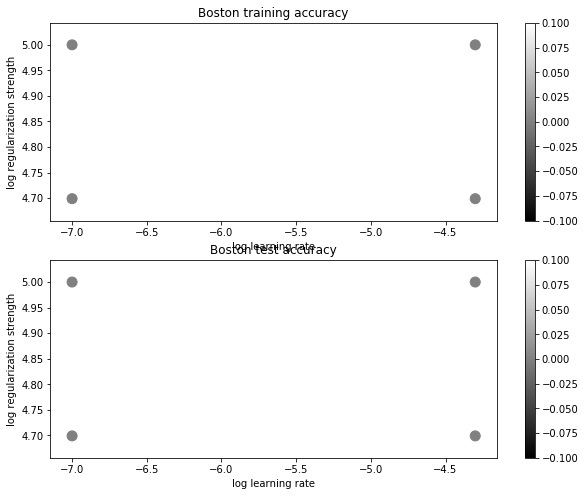

In [14]:
# Visualize kết quả kiểm thử chéo
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Boston training accuracy')

# vẽ hiệu năng trên tập kiểm tra
colors = [results[x][1] for x in results] # kích thước mặc định của marker là 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Boston test accuracy')
plt.show()